In [1]:
import torch
import torch.nn as nn

device = device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [21]:
import ssm 

class Byter(nn.Module):
    def __init__(self, input_size = 256, output_size = 64, conv_in = 256, ssm_in = 64,dtype = torch.float16):
        super(Byter, self).__init__()
        
        self.inlin = nn.Linear(input_size, conv_in, dtype=dtype)
        self.conv1 = nn.Sequential(
            nn.Conv1d(1,1,2, dtype=dtype),
            nn.Conv1d(1,1,2, dtype=dtype),
            nn.Conv1d(1,1,2, dtype=dtype),
            nn.Conv1d(1,1,2, dtype=dtype),
        )

        self.conv2 = nn.Sequential(
            nn.Conv1d(1,1,4, dtype=dtype),
            nn.Conv1d(1,1,4, dtype=dtype)
        )

        self.conv3 = nn.Conv1d(1, 1, 8, dtype=dtype)
        self.convout = nn.Sequential(nn.LazyLinear(out_features=ssm_in, dtype=dtype), nn.ReLU())
        self.ssm = ssm.SSM(ssm_in, 64, output_size=output_size, dtype=dtype)
        self.passthrough = nn.Sequential(nn.Linear(input_size, output_size, dtype=dtype), nn.ReLU())
        self.out = nn.Linear(output_size, output_size, dtype=dtype)


    def forward(self, x):
        i = self.inlin(x).unsqueeze(0).unsqueeze(0)
        c1 = self.conv1(i).squeeze(0).squeeze(0)
        c2 = self.conv2(i).squeeze(0).squeeze(0)
        c3 = self.conv3(i).squeeze(0).squeeze(0)
        print(c1.shape, c2.shape, c3.shape)
        i = self.convout(torch.cat((c1, c2, c3)))
        i = self.ssm(i) * self.passthrough(x)
        return self.out(i)


In [23]:
input_size = 256
output_size = 8
dtype = torch.float16

test_seq = torch.randn(256, dtype=dtype)

model = Byter(dtype=dtype)
model(test_seq)

torch.Size([252]) torch.Size([250]) torch.Size([249])


tensor([-0.2137, -0.0153, -0.0913, -0.1173,  0.1997, -0.0426,  0.1700,  0.1671,
        -0.1639,  0.1079, -0.0840, -0.0636, -0.0051,  0.1198,  0.0596,  0.0257,
        -0.1588,  0.0695, -0.0635, -0.2448, -0.0591, -0.0899,  0.0150,  0.0272,
         0.0789,  0.1158,  0.0470,  0.0481, -0.0768,  0.0442,  0.1033, -0.1047,
        -0.0103,  0.0342,  0.0208,  0.0660, -0.1935, -0.0264,  0.2290,  0.1404,
         0.0293, -0.0027,  0.1175,  0.0019,  0.2360,  0.1035, -0.1230,  0.0434,
        -0.0152, -0.1121, -0.0081,  0.2405, -0.0446,  0.0501, -0.0689, -0.1237,
        -0.2722, -0.0214, -0.1492,  0.0657, -0.0608,  0.0296, -0.2032,  0.0751],
       dtype=torch.float16, grad_fn=<ViewBackward0>)

In [9]:
import librosa

array, sampling_rate =librosa.load('voice_audio/44khello.wav')

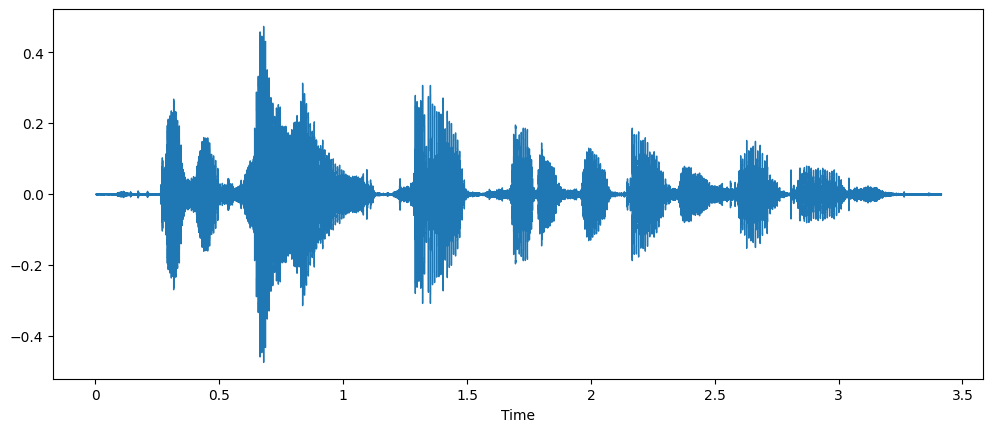

In [10]:
import matplotlib.pyplot as plt
import librosa.display

plt.figure().set_figwidth(12)
librosa.display.waveshow(array, sr=sampling_rate)

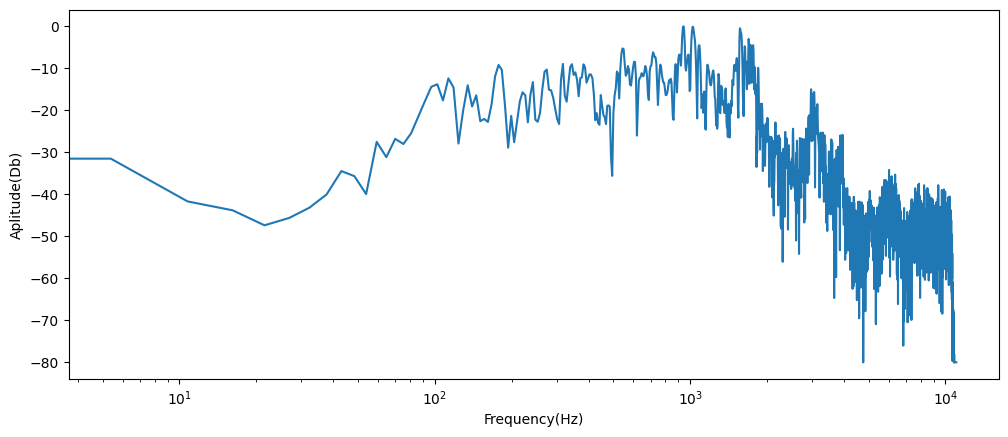

In [11]:
import numpy as np

dft_input = array[:4096]

window = np.hanning(len(dft_input))
windowed_input = dft_input * window
dft = np.fft.rfft(windowed_input)

amplitude = np.abs(dft)
amplitude_db = librosa.amplitude_to_db(amplitude, ref=np.max)

frequency = librosa.fft_frequencies(sr=sampling_rate, n_fft=len(dft_input))

plt.figure().set_figwidth(12)
plt.plot(frequency, amplitude_db)
plt.xlabel("Frequency(Hz)")
plt.ylabel("Aplitude(Db)")
plt.xscale("log")

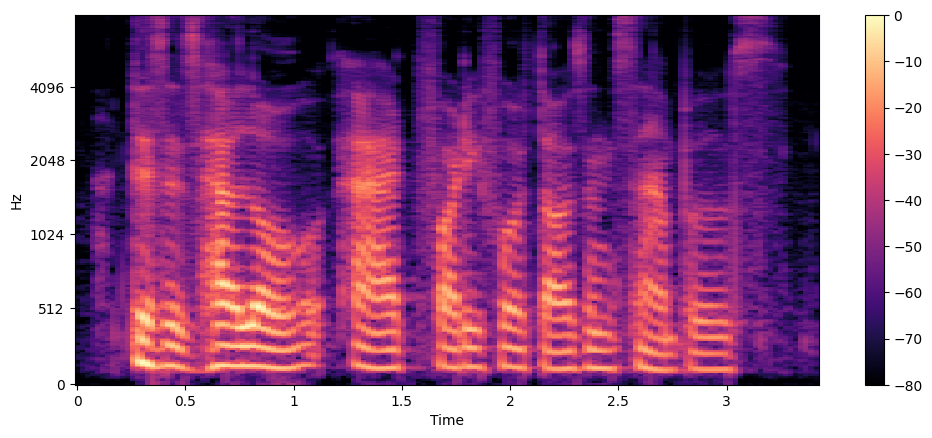

In [16]:
S = librosa.feature.melspectrogram(y=array, sr=sampling_rate, n_mels=256, fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_dB, x_axis="time", y_axis="mel", sr=sampling_rate, fmax=8000)
plt.colorbar()

In [18]:
from datasets import load_dataset

minds = load_dataset("PolyAI/minds14", name="en-AU", split="train")
minds

/home/nullptr/anaconda3/envs/ai_shit/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating train split: 654 examples [00:00, 30635.53 examples/s]


Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 654
})

In [19]:
example = minds[0]
example

{'path': '/home/nullptr/.cache/huggingface/datasets/downloads/extracted/4a6dd5bee5672f744c10ed7932320c62c3e167c384f03a87651c778f82b3b312/en-AU~PAY_BILL/response_4.wav',
 'audio': {'path': '/home/nullptr/.cache/huggingface/datasets/downloads/extracted/4a6dd5bee5672f744c10ed7932320c62c3e167c384f03a87651c778f82b3b312/en-AU~PAY_BILL/response_4.wav',
  'array': array([ 0.        ,  0.00024414, -0.00024414, ..., -0.00024414,
          0.00024414,  0.0012207 ]),
  'sampling_rate': 8000},
 'transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'english_transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'intent_class': 13,
 'lang_id': 2}